<a href="https://colab.research.google.com/github/aCStandke/ReinforcementLearning/blob/main/SecondStockEnivornment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second Stock Trading Environment


  This second stock environment is based on Adam King's article as found here:[Create custom gym environments from scratch — A stock market example](https://towardsdatascience.com/creating-a-custom-openai-gym-environment-for-stock-trading-be532be3910e). Similar to the first stock trading environment based on Maxim Lapan's implementation as found in chapter eight of his book [Deep Reinforcement Learning Hands-On: Apply modern RL methods to practical problems of chatbots, robotics, discrete optimization, web automation, and more, 2nd Edition](https://www.amazon.com/Deep-Reinforcement-Learning-Hands-optimization/dp/1838826998), the agent is trading in the environment of the [SPY ETF](https://www.etf.com/SPY?L=1) except in this trading environment the agent is taking continuous actions, rather than discrete actions and is tasked with managing a [trading account](https://www.investopedia.com/terms/t/tradingaccount.asp#:~:text=A%20trading%20account%20is%20an,margin%20requirements%20set%20by%20FINRA.).  



---


  In the first trading environment, the agent's reward is based on relative price movement, however in this trading environment the agent's reward is based on managing its trading account. As Adam King details the agent can take two actions: 1) either buying or selling the SPY ETF (note: eventhough this decision is discrete in nature, it is being modeled as a continous action by making values less than 1.0 as buy actions and values greater than 1.0 and less than 2.0 as sell actions);  and 2) by what percentage of the SPY ETF's shares to buy or sell, which ranges in the continous interval of [0-1] (i.e. 0% to 100%).











In [1]:
# ignore warning messages because they are annoying lol
import warnings
warnings.filterwarnings('ignore')

# Installing Necessary Package for Training the Trading Agent

To train the Trading Agent the package [Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/index.html) was used. As stated in the docs: 
> Stable Baselines3 (SB3) is a set of reliable implementations of reinforcement learning algorithms in PyTorch. It is the next major version of Stable Baselines. And steems from the paper [Stable-Baselines3: Reliable Reinforcement Learning Implementations](https://jmlr.org/papers/volume22/20-1364/20-1364.pdf)
The algorithms in this package will make it easier for the research community and industry to replicate, refine, and identify new ideas, and will create good baselines to build projects on top of. We expect these tools will be used as a base around which new ideas can be added, and as a tool for comparing a new approach against existing ones. We also hope that the simplicity of these tools will allow beginners to experiment with a more advanced toolset, without being buried in implementation details.

---
## Proximal Policy Optimization(PPO):

Because in this environment the Agent will be executing continous actions, the Proximal Policy Optimization(PPO) algorithm was chosen. As detailed by the authors [PPO](https://arxiv.org/pdf/1707.06347.pdf)


> We propose a new family of policy gradient methods for reinforcement learning, which alternate between sampling data through interaction with the environment, and optimizing a “surrogate” objective function using stochastic gradient ascent. Whereas standard policy gradient methods perform one gradient update per data sample, we propose a novel objective function that enables multiple epochs of minibatch updates. The new methods, which we call proximal policy optimization (PPO), have some of the benefits of trust region policy optimization (TRPO), but they are much simpler to implement, more general, and have better sample complexity (empirically).


PPO uses the following novel objective function:

$L^{CLIP}(θ)=\hat{E}_t[min(r_{t}(θ)\hat{A}_t,clip(r_{t}(θ), 1-ϵ, 1+ϵ)\hat{A}_t]$

*  $\theta$ is the policy parameter
*  $\hat{E}_t$ denotes the empirical expectation over timesteps
*  $r_{t}$ is the ratio of the probability under the new and old policies, respectively
*  $\hat{A}_t$ is the estimated advantage at time t
*  $\epsilon$ is the clipping hyperparameter, usually 0.1 or 0.2


As detailed by the authors [openAI](https://openai.com/blog/openai-baselines-ppo/#ppo)


> This objective implements a way to do a Trust Region update which is compatible with Stochastic Gradient Descent, and simplifies the algorithm by removing the KL penalty and need to make adaptive updates. In tests, this algorithm has displayed the best performance on continuous control tasks and almost matches ACER’s performance on Atari, despite being far simpler to implement


  









In [2]:
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 12.1 MB/s 
     |████████████████████████████████| 1.5 MB 56.6 MB/s 
     |████████████████████████████████| 1.6 MB 53.4 MB/s 
     |████████████████████████████████| 162 kB 63.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616824 sha256=f0e9cacf7a7aec032f06b945fc82d771a383821b03ed9c46fcfb71110040ef2d
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=cce4a6d882346b92e46d9878aca974e7720283b7267bd06c0af7cc1653049475
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c4

# Installing the Necessary Packages for Visualizing the Trading Agent's Envirnoment on Google Colab Notebooks

In [3]:
!pip install mpl_finance #used for plotting the candelstick graph
!pip install moviepy #
!pip install imageio_ffmpeg #
!pip install pyvirtualdisplay > /dev/null 2>&1 #used to create a display for vm
!apt-get install x11-utils > /dev/null 2>&1 #
!pip install pyglet==v1.3.2 > /dev/null 2>&1 #
!apt-get install -y xvfb python-opengl > /dev/null 2>&1 #

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.4 MB/s 


In [4]:
import random
import json
import gym
from gym import spaces
from gym.utils import seeding
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import json
import datetime as dt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
import collections
import datetime
from mpl_finance import candlestick_ochl as candlestick
import math
import os
import moviepy.video.io.ImageSequenceClip
import glob
import re
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [5]:
# Stock Environment Parameters
MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
TRADING_DAYS = 5
DEFAULT_COMMISSION_PERC = 0.01
MAX_STEPS = 20000
INITIAL_ACCOUNT_BALANCE = 10000

# Visualization Parameters
style.use('dark_background')
VOLUME_CHART_HEIGHT = 0.33
UP_COLOR = '#27A59A'
DOWN_COLOR = '#EF534F'
UP_TEXT_COLOR = '#73D3CC'
DOWN_TEXT_COLOR = '#DC2C27'
LOOKBACK_WINDOW_SIZE = 10

# Video Parameters
fps=1
display = Display(visible=0, size=(1400, 900))
display.start()

 ## Creating visualization for Stock/ETF Environment
 As detalied by Adam King in his article titled
 [Rendering elegant stock trading agents using Matplotlib 
 and Gym](https://towardsdatascience.com/visualizing-stock-trading-agents-using-matplotlib-and-gym-584c992bc6d4)

In [6]:
def date2num(date):
  converter = mdates.strpdate2num('%Y-%m-%d')
  return converter(date)

class StockTradingGraph:
  """A stock trading visualization using matplotlib made to render 
    OpenAI gym environments"""
  def __init__(self, df, title=None):
    self.df = df
    self.net_worths = np.zeros(len(df.date))
    self.count = 0
    self._step = 0

    # Create a figure on screen and set the title
    fig = plt.figure()
    fig.suptitle(title)
    # Create top subplot for net worth axis
    self.net_worth_ax = plt.subplot2grid(shape=(6, 1), loc=(0, 0), rowspan=2,     
      colspan=1)
  
    # Create bottom subplot for shared price/volume axis
    self.price_ax = plt.subplot2grid(shape=(6, 1), loc=(2, 0), rowspan=8, 
      colspan=1, sharex=self.net_worth_ax)
    # Create a new axis for volume which shares its x-axis with price
    self.volume_ax = self.price_ax.twinx()
    # Add padding to make graph easier to view
    plt.subplots_adjust(left=0.11, bottom=0.24, right=0.90, 
      top=0.90, wspace=0.2, hspace=0)
    
  
  def render(self, current_step, net_worth, trades, window_size=40):
    self.net_worths[current_step] = net_worth
    window_start = max(current_step - window_size, 0)
    step_range = range(window_start, current_step + 1)
    # Format dates as timestamps, necessary for candlestick graph
    dates = np.array([date2num(x) for x in self.df.date[step_range]])

    self._render_net_worth(current_step, net_worth, step_range, dates)
    self._render_price(current_step, net_worth, dates, step_range)
    self._render_volume(current_step, net_worth, dates, step_range)
    self._render_trades(current_step, trades, step_range)
        
    # Format the date ticks to be more easily read
    self.price_ax.set_xticklabels(self.df.date[step_range], rotation=45, ha='right')
        
    # Hide duplicate net worth date labels
    plt.setp(self.net_worth_ax.get_xticklabels(), visible=False)
    # Necessary to view frames before they are unrendered  
    if self.count < 1:
      plt.savefig(f'{current_step}.png')
      self._step = current_step
      self.count += 1
    else: 
      if self._step + LOOKBACK_WINDOW_SIZE==current_step: 
        plt.savefig(f'{current_step}.png')
        self._step = current_step

  def _render_net_worth(self, current_step, net_worth, step_range, dates):
    # Clear the frame rendered last step
    self.net_worth_ax.clear()

    # Plot net worths
    self.net_worth_ax.plot_date(dates, self.net_worths[step_range],
                                '-', label='Net Worth')

    # Show legend, which uses the label we defined for the plot above
    self.net_worth_ax.legend()
    legend = self.net_worth_ax.legend(loc=2, ncol=2, prop={'size': 8})
    legend.get_frame().set_alpha(0.4)

    last_date = date2num(self.df.date[current_step])
    last_net_worth = self.net_worths[current_step]

    # Annotate the current net worth on the net worth graph
    self.net_worth_ax.annotate('{0:.2f}'.format(net_worth), (last_date, last_net_worth),
                                   xytext=(last_date, last_net_worth),
                                   bbox=dict(boxstyle='round',
                                             fc='w', ec='k', lw=1),
                                   color="black",
                                   fontsize="small")

    # Add space above and below min/max net worth
    self.net_worth_ax.set_ylim(
            min(self.net_worths[np.nonzero(self.net_worths)]) / 1.25, max(self.net_worths) * 1.25)
    

  def _render_price(self, current_step, net_worth, dates, step_range):
        self.price_ax.clear()

        # Format data for OHCL candlestick graph
        candlesticks = zip(dates,
                           self.df.open[step_range], self._cur_close(step_range),
                           self._cur_high(step_range), self._cur_low(step_range))

        # Plot price using candlestick graph from mpl_finance
        candlestick(self.price_ax, candlesticks, width=0.5,
                    colorup=UP_COLOR, colordown=DOWN_COLOR)

        last_date = date2num(self.df.date[current_step])
        last_close = self._cur_close(current_step)
        last_high = self._cur_high(current_step)

        # Print the current price to the price axis
        self.price_ax.annotate('{0:.2f}'.format(last_close), (last_date, last_close),
                               xytext=(last_date, last_high),
                               bbox=dict(boxstyle='round',
                                         fc='w', ec='k', lw=1),
                               color="black",
                               fontsize="small")

        # Shift price axis up to give volume chart space
        ylim = self.price_ax.get_ylim()
        self.price_ax.set_ylim(ylim[0] - (ylim[1] - ylim[0])
                               * VOLUME_CHART_HEIGHT, ylim[1])
        
  def _render_volume(self, current_step, net_worth, dates, step_range):
        self.volume_ax.clear()

        volume = np.array(self.df.volume[step_range])

        pos = self.df.open[step_range] - \
            self._cur_close([step_range]) < 0
        neg = self.df.open[step_range] - \
            self._cur_close([step_range]) > 0


        # Color volume bars based on price direction on that date
        self.volume_ax.bar(dates[pos], volume[pos], color=UP_COLOR,
                           alpha=0.4, width=0.5, align='center')
        self.volume_ax.bar(dates[neg], volume[neg], color=DOWN_COLOR,
                           alpha=0.4, width=0.5, align='center')

        # Cap volume axis height below price chart and hide ticks
        self.volume_ax.set_ylim(0, max(volume) / VOLUME_CHART_HEIGHT)
        self.volume_ax.yaxis.set_ticks([])
       

  def _render_trades(self, current_step, trades, step_range):
    for trade in trades:
      if trade['step'] in step_range:
        date = date2num(self.df.date[trade['step']])
        high = self._cur_high(trade['step'])
        low = self._cur_low(trade['step'])
         
        if trade['type'] == 'buy':
          high_low = low
          color = UP_TEXT_COLOR
        else:
          high_low = high
          color = DOWN_TEXT_COLOR
        
        total = '{0:.2f}'.format(trade['total'])
        
        # Print the current price to the price axis
        self.price_ax.annotate(f'${total}', (date, high_low),
                             xytext=(date, high_low),
                             color=color,
                             fontsize=8,
                             arrowprops=(dict(color=color)))
                
  def _cur_close(self, offset):
      """
      Calculate real close price for the current bar
      """
      open = self.df.open[offset]
      rel_close = self.df.close[offset]
      return open * (1.0 + rel_close)

  def _cur_high(self, offset):
      """
      Calculate real close price for the current bar
      """
      open = self.df.open[offset]
      rel_high = self.df.high[offset]
      return open * (1.0 + rel_high)

  def _cur_low(self, offset):
      """
      Calculate real close price for the current bar
      """
      open = self.df.open[offset]
      rel_low = self.df.low[offset]
      return open * (1.0 + rel_low)

  def close(self):
    plt.close()
              
  

In [7]:
step=range(0, 13)

In [8]:
step.start:step.stop+2

In [9]:
# Stock/ETF Trading Enviornment
class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, data, random_ofs_on_reset=True, commission_prec=DEFAULT_COMMISSION_PERC):
        super(StockTradingEnv, self).__init__()

        self.data = data
        self.random_ofs_on_reset = random_ofs_on_reset
        self.bars_count = TRADING_DAYS
        self.commission_perc = commission_prec
        self.visualization = None 
        self.track_reward = 0
        

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Box(
            low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float32)

        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
            low=-1, high=1, shape=self.shape, dtype=np.float32)
        
        self.random_ofs_on_reset = random_ofs_on_reset
        self.seed()

    def reset(self):
      bars = self.bars_count
      if self.random_ofs_on_reset:
        offset = self.np_random.choice(self.data.high.shape[0]-bars*10)+bars
      else:
        offset = bars
      self._reset(offset)
      return self._next_observation()  

    @property
    def shape(self):
      return (4*self.bars_count+6, )

    def _next_observation(self):
        # Get the stock data points for the last 5 days and scale to between 0-1
        res = np.ndarray(shape=self.shape, dtype=np.float32)
        shift = 0
        for bar_idx in range(-self.bars_count+1, 1):
          res[shift] = self.data.high[self._offset + bar_idx]
          shift += 1
          res[shift] = self.data.low[self._offset + bar_idx]
          shift += 1
          res[shift] = self.data.close[self._offset + bar_idx]
          shift += 1
          res[shift] = self.data.volume[self._offset + bar_idx]
          shift += 1

        # Append additional data and scale each value to between 0-1
        res[shift] = self.balance / MAX_ACCOUNT_BALANCE
        shift += 1
        res[shift] = self.netWorth/ MAX_ACCOUNT_BALANCE
        shift += 1
        res[shift] = self.shares_held / MAX_NUM_SHARES
        shift += 1
        res[shift] = self.total_shares_sold / MAX_NUM_SHARES
        shift += 1
        res[shift] = self.total_sales_value/ MAX_NUM_SHARES
        shift += 1
        res[shift] = self.cost_basis / MAX_NUM_SHARES
        return res

    def _take_action(self, action):
      current_price = self._cur_close()
      action_type = action[0]
      amount = action[1]

      if action_type < 1 and int(amount) > 0:
        # Buy amount % of balance in shares
        total_possible = self.balance / current_price
        shares_bought = total_possible * amount
        prev_cost = self.cost_basis * self.shares_held
        additional_cost = shares_bought * current_price
        self.balance -= additional_cost
        self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)
        self.shares_held += shares_bought
        
        
        # visualization portion
        if shares_bought > 0:
          self.trades.append({'step': self._offset, 'shares': shares_bought, 
                              'total': additional_cost, 'type': "buy"})
          
      elif action_type < 2 and int(amount) > 0:
        # Sell amount % of shares held
        shares_sold = self.shares_held * amount  
        self.balance += shares_sold * current_price
        self.shares_held -= shares_sold
        self.total_shares_sold += shares_sold
        self.total_sales_value += shares_sold * current_price
        

        # visualization portion
        if shares_sold > 0:
          self.trades.append({'step': self._offset, 'shares': shares_sold, 
                                  'total': shares_sold * current_price, 'type': "sell"})  
          
      
      self.netWorth = self.balance + self.shares_held * current_price
      
      if self.netWorth > self.max_net_worth:
        self.max_net_worth = self.netWorth
      
      if self.shares_held == 0:
        self.cost_basis = 0

    def _cur_close(self):
      """
      Calculate real close price for the current bar
      """
      open = self.data.open[self._offset]
      rel_close = self.data.close[self._offset]
      return open * (1.0 + rel_close)

    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)

        self._offset += 1

        if self._offset >= self.data.close.shape[0]-1 or self.netWorth <= 0:
          done=True
        else:
          done=False
        
        delay_modifier = (self._offset / MAX_STEPS)
        reward = self.balance * delay_modifier
        self.track_reward = reward
        obs = self._next_observation()

        return obs, reward, done, {}

    def _reset(self, offset):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.netWorth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self._offset = offset
        self.trades = []
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0


    def _render_to_file(self, filename='render.txt'):
      f = open(filename, 'a+')
      f.write(f"Step: {self._offset}\n")
      f.write(f"Date: {self.data.date[self._offset]}\n")
      f.write(f"Balence: {self.balance}\n")
      f.write(f"Reward: {self.track_reward}\n")
      f.write(f"Amount Held: {self.shares_held}\n") 
      f.write(f"Amount Sold: {self.total_shares_sold}\n)")
      #add some more
      f.close()

    def render(self, mode='live', title="Agent's Trading Screen", **kwargs):
      # Render the environment to the screen
      if mode == 'file':
        self._render_to_file(kwargs.get('filename', 'render.txt'))
      elif mode == 'live':
        if self.visualization == None:
          self.visualization = StockTradingGraph(self.data, title)
        if self._offset > LOOKBACK_WINDOW_SIZE:
          self.visualization.render(self._offset, self.netWorth,
                                    self.trades, window_size=LOOKBACK_WINDOW_SIZE)


    def seed(self, seed=None):
      self.np_random, seed1 = seeding.np_random(seed)
      seed2 = seeding.hash_seed(seed1+1) % 2**33
      return [seed1, seed2]


In [10]:
# Training data
df = pd.read_csv('/content/drive/MyDrive/Datasets/StockMarketData/archive/Data/ETFs/spy.us.txt')
df = df.sort_values('Date')
data=df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# year data of year-month-day form
dt = data['Date'].array
# calculating relative prices 
rh = (data['High'].values-data['Open'].values)/data['Open'].values
rl = (data['Low'].values-data['Open'].values)/data['Open'].values
rc = (data['Close'].values-data['Open'].values)/data['Open'].values
o = data['Open'].values
# volumne data
vol = data['Volume'].values/MAX_NUM_SHARES

Data = collections.namedtuple('Data', field_names=['date','high', 'low', 'close', 'open', 'volume'])
data=Data(date=dt,high=rh, low=rl, close=rc, open=o, volume=vol)

In [11]:
# Testing data
test = pd.read_csv('/content/drive/MyDrive/Datasets/StockMarketData/test.csv')
t_df = test.sort_values('Date')
data_two=t_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# year data of year-month-day form
dt = data_two['Date'].array
# calculating relative prices 
rh = (data_two['High'].values-data_two['Open'].values)/data_two['Open'].values
rl = (data_two['Low'].values-data_two['Open'].values)/data_two['Open'].values
rc = (data_two['Close'].values-data_two['Open'].values)/data_two['Open'].values
o = data_two['Open'].values
# volumne data
vol = data_two['Volume'].values/MAX_NUM_SHARES

Data_two = collections.namedtuple('Data', field_names=['date','high', 'low', 'close', 'open', 'volume'])
test_data=Data_two(date=dt,high=rh, low=rl, close=rc, open=o, volume=vol)

# Training and Validation Portion

In [35]:
# number of learning steps to train RL model is set to 500 thousand
MAX_STEPS = 1e3

# create evaluation env that takes in test data for validation
eval_env = DummyVecEnv([lambda: StockTradingEnv(test_data, random_ofs_on_reset=True)])
# use deterministic actions for evaluation callback
eval_callback = EvalCallback(eval_env, best_model_save_path='/content/drive/MyDrive/RLmodels/bestPPO/',
                             log_path='/content/drive/MyDrive/RLmodels/logs/', eval_freq=MAX_STEPS/10,
                             deterministic=False, render=False)

# create training env that takes in training data for training
env =  DummyVecEnv([lambda: StockTradingEnv(data, random_ofs_on_reset=True)])
model = PPO("MlpPolicy", env)

In [36]:
model.learn(total_timesteps=MAX_STEPS, callback=eval_callback)

Eval num_timesteps=100, episode_reward=481770.83 +/- 287579.64
Episode length: 361.40 +/- 148.73
New best mean reward!
Eval num_timesteps=200, episode_reward=547758.72 +/- 257459.13
Episode length: 557.20 +/- 328.56
New best mean reward!
Eval num_timesteps=300, episode_reward=864429.32 +/- 556359.09
Episode length: 448.20 +/- 253.68
New best mean reward!
Eval num_timesteps=400, episode_reward=480721.60 +/- 309835.73
Episode length: 570.80 +/- 505.31
Eval num_timesteps=500, episode_reward=640845.82 +/- 337188.10
Episode length: 509.40 +/- 170.15
Eval num_timesteps=600, episode_reward=1009000.62 +/- 481344.58
Episode length: 733.40 +/- 397.95
New best mean reward!
Eval num_timesteps=700, episode_reward=1119041.32 +/- 391899.76
Episode length: 775.60 +/- 196.62
New best mean reward!
Eval num_timesteps=800, episode_reward=542912.89 +/- 300114.21
Episode length: 586.00 +/- 376.63
Eval num_timesteps=900, episode_reward=1143597.43 +/- 445744.57
Episode length: 647.60 +/- 374.71
New best mean 

# Prediction and Rendering Environment Portion

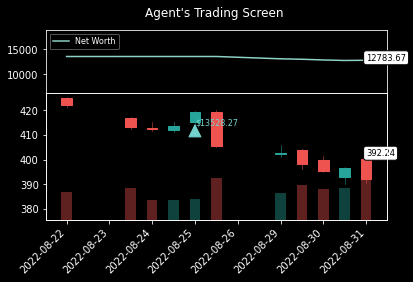

In [37]:
model = PPO.load("/content/drive/MyDrive/RLmodels/bestPPO/best_model.zip")
env = StockTradingEnv(test_data, random_ofs_on_reset=False)
obs = env.reset()
for i in range(len(test_data.date)):
  action, _states = model.predict(obs, deterministic=False)
  obs, rewards, done, info = env.step(action)
  env.render()
  if done:
    break

In [38]:
# taken from https://stackoverflow.com/questions/5967500/how-to-correctly-sort-a-string-with-a-number-inside

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

list_of_files = [img for img in os.listdir('/content') if img.endswith(".png")]
list_of_files.sort(key=natural_keys)

In [39]:
# taken from https://stackoverflow.com/questions/44947505/how-to-make-a-movie-out-of-images-in-python
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(list_of_files, fps=fps)
clip.write_videofile('agent_trading.mp4')

[MoviePy] >>>> Building video agent_trading.mp4
[MoviePy] Writing video agent_trading.mp4


 99%|█████████▉| 120/121 [00:00<00:00, 162.10it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: agent_trading.mp4 



In [40]:
# taken from https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=8nj5sjsk15IT

def show_video():
  mp4list = glob.glob('agent_trading.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [41]:
show_video()

In [34]:
!rm -r *.png